In [1]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Inteligencia Artificial - I/Opción I')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1lBhm112YiMUZzXUG1wX-mKCH1zi7fLPe/Opción I


In [ ]:


#import os
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Opción I')
print(os.getcwd())"""



Evaluación de modelos de machine learning en la clasificación de litologías a partir de registros de pozo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import tensorflow as tf
from tensorflow import keras
from collections import Counter
sns.set_theme()

In [3]:
full_Dataset = pd.DataFrame(pd.read_csv("train.csv",delimiter=";"))
d_tst = pd.DataFrame(pd.read_csv("test.csv",delimiter=";"))

In [4]:
full_Dataset.shape

(1170511, 29)

In [5]:
full_Dataset.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,NaN,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


In [6]:
"""
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'} """

#Aunque el dataset original cuenta con varios tipos de etiqueta decidimos reducirlos a tres 
# Shale y Arenas, dos litologías de interés debido a la importancia de los Shale a la hora de operaciones y problemas técnicos
#  y la importancia de las arenas por su capacidad de almacenar hidrocarburos, ignoratemos en este caso las arenas sucias que
# tengan porcentaje de shale, aún así pueden almacenar hcs, al reducir las etiquetas esperamos mejorar la precisión en la clasificación
# de las litologías de interés
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone',
                 65000: 'Shale',
                 80000: 'NoI',
                 74000: 'NoI',
                 70000: 'NoI',
                 70032: 'NoI',
                 88000: 'NoI',
                 86000: 'NoI',
                 99000: 'NoI',
                 90000: 'NoI',
                 93000: 'NoI'}                 

#Antes de arreglar el dataset

In [7]:
# -- Areglar el dataset 
# Features of interest
# Tomamos como características de interes todos los registros del dataset
columns = ['Z_LOC','CALI',	'RSHA',	'RMED',	'RDEP',	'RHOB',	'GR',	'SGR',
           'NPHI',	'PEF',	'DTC',	'SP',	'BS',	'ROP',	'DTS',	'DCAL',	'DRHO',
           'ROPA',	'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY']

data = full_Dataset[columns]

data['FORCE_2020_LITHOFACIES_LITHOLOGY'].replace(lithology_keys, inplace=True)
data

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY
0,-469.501831,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,Shale
1,-469.653809,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,Shale
2,-469.805786,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,Shale
3,-469.957794,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,Shale
4,-470.109772,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,NaN,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,NaN,-0.597914,NaN,NaN,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,NaN,8.423170,NaN,NaN,NaN,2.527984,77.654900,NaN,NaN,4.586425,NaN,NaN,8.5,27.674368,NaN,NaN,-0.001763,26.673708,NaN,Sandstone
1170507,NaN,8.379244,NaN,NaN,NaN,2.537613,75.363937,NaN,NaN,7.019858,NaN,NaN,8.5,28.024338,NaN,NaN,-0.007600,26.840818,NaN,Sandstone
1170508,NaN,8.350248,NaN,NaN,NaN,2.491860,66.452843,NaN,NaN,9.049782,NaN,NaN,8.5,28.091282,NaN,NaN,-0.018297,27.007942,NaN,Sandstone
1170509,NaN,8.313779,NaN,NaN,NaN,2.447539,55.784817,NaN,NaN,8.903917,NaN,NaN,8.5,28.019775,NaN,NaN,-0.011438,27.175179,NaN,Sandstone


In [8]:
data.isna().any()
##Solo Gamma Ray presenta todos los valores, los demas presentan algún NaN

Z_LOC                                True
CALI                                 True
RSHA                                 True
RMED                                 True
RDEP                                 True
RHOB                                 True
GR                                  False
SGR                                  True
NPHI                                 True
PEF                                  True
DTC                                  True
SP                                   True
BS                                   True
ROP                                  True
DTS                                  True
DCAL                                 True
DRHO                                 True
ROPA                                 True
RXO                                  True
FORCE_2020_LITHOFACIES_LITHOLOGY    False
dtype: bool

In [9]:
print(data.isna().sum()*100/data.shape[0])

Z_LOC                                0.920538
CALI                                 7.507576
RSHA                                46.121822
RMED                                 3.331280
RDEP                                 0.941042
RHOB                                13.777658
GR                                   0.000000
SGR                                 94.074981
NPHI                                34.608987
PEF                                 42.615490
DTC                                  6.908350
SP                                  26.164983
BS                                  41.678720
ROP                                 54.287401
DTS                                 85.082327
DCAL                                74.469868
DRHO                                15.604638
ROPA                                83.569142
RXO                                 72.027004
FORCE_2020_LITHOFACIES_LITHOLOGY     0.000000
dtype: float64


In [10]:
#Eliminamos los registros que presentan un procentaje de ausencia mayor al 50%
## SGR: Spectral Gamma Ray
## ROP: Rate of Penetration
## DTS: Sonic (Sheer Slowness)
## RXO: Resistivity of flushed zone.
## ROPA
## DCAL
data = data.drop(columns=['SGR','PEF','DTS','ROPA','RXO','DCAL','RSHA'])
data.shape

(1170511, 13)

In [ ]:
n = int(len(data)*0.01)
dpp = data.iloc[:n]
sns.pairplot(dpp, hue="FORCE_2020_LITHOFACIES_LITHOLOGY", diag_kind="hist");# kind="kde")

Output hidden; open in https://colab.research.google.com to view.

In [11]:
listDict = []
col = data.columns[:-1]
for i in col:
  print(i)
  listDict.append(data.groupby(['FORCE_2020_LITHOFACIES_LITHOLOGY'])[i].mean().to_dict())
  
listDict
#meanROP = data.groupby(['FORCE_2020_LITHOFACIES_LITHOLOGY'])['ROP'].mean()
#meanROP = meanROP.to_dict()
#data.groupby(['FORCE_2020_LITHOFACIES_LITHOLOGY'])['ROP'].mean().to_dict()

Z_LOC
CALI
RMED
RDEP
RHOB
GR
NPHI
DTC
SP
BS
ROP
DRHO


[{'NoI': -2290.497090782934,
  'Sandstone': -2283.449911003886,
  'Shale': -2048.2949855175634},
 {'NoI': 12.708546005391545,
  'Sandstone': 12.498735237207503,
  'Shale': 13.579110446922245},
 {'NoI': 6.757935074994842,
  'Sandstone': 5.4643026681672255,
  'Shale': 4.48177294438474},
 {'NoI': 61.28045348792863,
  'Sandstone': 7.9616666779933105,
  'Shale': 3.1696836924344365},
 {'NoI': 2.4015364203055696,
  'Sandstone': 2.289451123151675,
  'Shale': 2.2597519264073607},
 {'NoI': 42.76589425243825,
  'Sandstone': 57.04217070501952,
  'Shale': 82.14917043539914},
 {'NoI': 0.2387139829076365,
  'Sandstone': 0.2617235945025672,
  'Shale': 0.3822790526921115},
 {'NoI': 89.48523433119344,
  'Sandstone': 104.37762837182075,
  'Shale': 121.81409659227833},
 {'NoI': 67.46978672300614,
  'Sandstone': 54.43752301634037,
  'Shale': 61.4145501839837},
 {'NoI': 11.56826728058151,
  'Sandstone': 11.338022856643295,
  'Shale': 12.270599509897611},
 {'NoI': 76.31924704263501,
  'Sandstone': 100.308523

In [12]:
for index,i in enumerate(listDict): # i es el diccionario de cada columna
  for j in i: ## J es el nombre de la litofacie
    data.iloc[:,index][(data['FORCE_2020_LITHOFACIES_LITHOLOGY']==j) & (data.iloc[:,index].isnull())] = i[j]
    
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Z_LOC,CALI,RMED,RDEP,RHOB,GR,NPHI,DTC,SP,BS,ROP,DRHO,FORCE_2020_LITHOFACIES_LITHOLOGY
0,-469.501831,19.480835,1.611410,1.798681,1.884186,80.200851,0.382279,161.131180,24.612379,12.2706,34.636410,-0.574928,Shale
1,-469.653809,19.468800,1.618070,1.795641,1.889794,79.262886,0.382279,160.603470,23.895531,12.2706,34.636410,-0.570188,Shale
2,-469.805786,19.468800,1.626459,1.800733,1.896523,74.821999,0.382279,160.173615,23.916357,12.2706,34.779556,-0.574245,Shale
3,-469.957794,19.459282,1.621594,1.801517,1.891913,72.878922,0.382279,160.149429,23.793688,12.2706,39.965164,-0.586315,Shale
4,-470.109772,19.453100,1.602679,1.795299,1.880034,71.729141,0.382279,160.128342,24.104078,12.2706,57.483765,-0.597914,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,-2283.449911,8.423170,5.464303,7.961667,2.527984,77.654900,0.261724,104.377628,54.437523,8.5000,27.674368,-0.001763,Sandstone
1170507,-2283.449911,8.379244,5.464303,7.961667,2.537613,75.363937,0.261724,104.377628,54.437523,8.5000,28.024338,-0.007600,Sandstone
1170508,-2283.449911,8.350248,5.464303,7.961667,2.491860,66.452843,0.261724,104.377628,54.437523,8.5000,28.091282,-0.018297,Sandstone
1170509,-2283.449911,8.313779,5.464303,7.961667,2.447539,55.784817,0.261724,104.377628,54.437523,8.5000,28.019775,-0.011438,Sandstone


In [13]:
print("Atributo         --      Porcentaje de NaN")
print(data.isna().sum()*100/data.shape[0]) ## Se elimin+o todos los null por el promedio de cada litofacie//litología

Atributo         --      Porcentaje de NaN
Z_LOC                               0.0
CALI                                0.0
RMED                                0.0
RDEP                                0.0
RHOB                                0.0
GR                                  0.0
NPHI                                0.0
DTC                                 0.0
SP                                  0.0
BS                                  0.0
ROP                                 0.0
DRHO                                0.0
FORCE_2020_LITHOFACIES_LITHOLOGY    0.0
dtype: float64


In [ ]:
#### CONSTRUCCIÓN DE DATASET TEST Y TRAIN CON 15% PARA TEST
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
data = shuffle(data)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [ ]:
#Para la primera entregar usaremos los modelos básicos de clasificación

#------ Use the estimators as they comes, with no other kind of data processing
## Naive-Gaussian-Bayes
## Decision Tree
## Random Forest
## Support Vector Machine

# ------ Using PCA - Features Importance (DT) - Curvas de aprendizaje  - LeaveOneOut

# ------ Usas Redes Neuronales 
# ------ Una sola capa intermedia
# ------ multicapa tanh, relu, elu (Softmax obligatoria en la capa de clases)

GNB Sin crossval
accuracy 0.406
GNB Con crossval
Desviación máxima:  0.16629536830393576
Media máxima:  0.5578488081661499


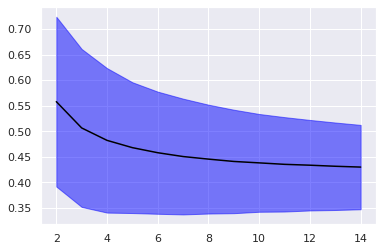

In [ ]:
## Naive-Guassian-Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import *

print("GNB Sin crossval")
estGB_2 = GaussianNB()
estGB_2.fit(X_train,y_train)
predict = estGB_2.predict(X_test)
acc = accuracy_score(y_test,predict)
print("accuracy %.3f"%acc)


print("GNB Con crossval")
scores = []
stds = []
folds = range(2,15,1)
for i in folds:
  estGB_1 = GaussianNB()
  s = cross_val_score(estGB_1, X, y, cv=KFold(i, shuffle=True), scoring=make_scorer(accuracy_score))
  scores.append(np.mean(s))   
  stds.append(np.std(s))
scores = np.r_[scores]
stds  = np.r_[stds]
print("Desviación máxima: ",np.max(stds))
print("Media máxima: ",np.max(scores))
plt.plot(folds, scores,label="mean", color="black")
plt.fill_between(folds, scores-stds, scores+stds, color="blue", alpha=.5, label="std")
plt.show()

Decision Tree Sin crossval
accuracy 0.887
Decision Tree con crossval
Desviación máxima:  0.0015808421464588698
Media máxima:  0.9944955667122212


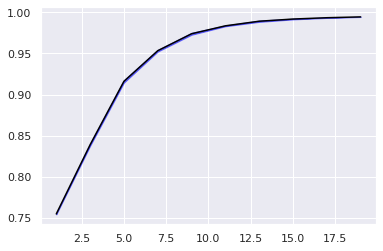

In [ ]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score



print("Decision Tree Sin crossval")
est = DecisionTreeClassifier(max_depth=4)
est.fit(X_train,y_train)
predict = est.predict(X_test)
acc = accuracy_score(y_test,predict)
print("accuracy %.3f"%acc)

scores = []
stds = []
depths = range(1,20,2)

print("Decision Tree con crossval")
for i in depths:
  est = DecisionTreeClassifier(max_depth=i)
  s = cross_val_score(est, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
  scores.append(np.mean(s))
  stds.append(np.std(s))

scores = np.r_[scores]
stds  = np.r_[stds]
print("Desviación máxima: ",np.max(stds))
print("Media máxima: ",np.max(scores))
plt.plot(depths, scores,label="mean", color="black")
plt.fill_between(depths, scores-stds, scores+stds, color="blue", alpha=.5, label="std")
plt.show()

Random Forest Sin crossval
accuracy 0.996
RF Curva de aprendizaje
Desviación máxima:  0.0010880336797218632
Media máxima:  0.9968219009029683


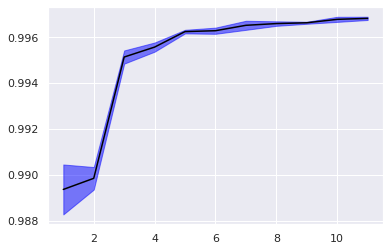

In [ ]:
#@title
## Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

print("Random Forest Sin crossval")  
est = RandomForestClassifier(n_estimators=5)
est.fit(X_train,y_train)
predict = est.predict(X_test)
acc = accuracy_score(y_test,predict)
print("accuracy %.3f"%acc)

scores = []
stds = []
estimators = range(1,12,1)
print("RF Curva de aprendizaje")
for i in estimators:
  est = RandomForestClassifier(n_estimators=i)
  s = cross_val_score(est, X, y, cv=KFold(4, shuffle=True), scoring=make_scorer(accuracy_score))
  scores.append(np.mean(s))
  stds.append(np.std(s))

scores = np.r_[scores]
stds  = np.r_[stds]
print("Desviación máxima: ",np.max(stds))
print("Media máxima: ",np.max(scores))
plt.plot(estimators, scores,label="mean", color="black")
plt.fill_between(estimators, scores-stds, scores+stds, color="blue", alpha=.5, label="std")
plt.show()

In [ ]:
atrr = np.array(X_train.columns)
atrr

array(['Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC', 'SP',
       'BS', 'ROP', 'DRHO'], dtype=object)

In [ ]:
##Features Importance - DT
atrr = np.array(X_train.columns)
est = DecisionTreeClassifier(max_depth=17) ##Se usará la mejor profundidad encontrada
est.fit(X_train,y_train)
features = est.feature_importances_
#predict = est.predict(X_test)
#acc = accuracy_score(y_test,predict)

In [ ]:
atrr = np.array(X_train.columns)
for i in range(len(atrr)):
  if features[i]>0.1:
    print(i,"-- ",atrr[i],": ",features[i])

6 --  NPHI :  0.3853774990557641
9 --  BS :  0.2114710781328516
10 --  ROP :  0.20475015082795653


In [ ]:
X_ftr = X.iloc[:,[6,9,10]];

Decision Tree sin crossval
DT - accuracy 0.880
Decision Tree con crossval
Desviación máxima:  0.0018801883834423025
Media máxima:  0.9377323239244202


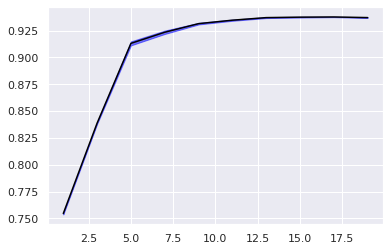

In [ ]:
X_train_ftrs = X_train.iloc[:,[6,9,10]]
x_test_ftrs =  X_test.iloc[:,[6,9,10]]
est = DecisionTreeClassifier(max_depth=4) 
est.fit(X_train_ftrs,y_train)
predict = est.predict(x_test_ftrs)
acc = accuracy_score(y_test,predict)
print("Decision Tree sin crossval")
print("DT - accuracy %.3f"%acc)


scores = []
stds = []
depths = range(1,20,2)

print("Decision Tree con crossval")
for i in depths:
  est = DecisionTreeClassifier(max_depth=i)
  s = cross_val_score(est, X_ftr, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
  scores.append(np.mean(s))
  stds.append(np.std(s))

scores = np.r_[scores]
stds  = np.r_[stds]
print("Desviación máxima: ",np.max(stds))
print("Media máxima: ",np.max(scores))
plt.plot(depths, scores,label="mean", color="black")
plt.fill_between(depths, scores-stds, scores+stds, color="blue", alpha=.5, label="std")
plt.show()

GNB sin CrossVal
GNB accuracy: 0.731
GNB Con crossval
Desviación máxima:  0.002094461497403956
Media máxima:  0.732023019968589


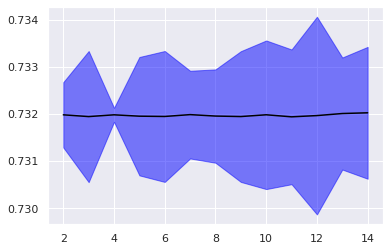

In [ ]:
X_train_ftrs = X_train.iloc[:,[6,9,10]]
x_test_ftrs =  X_test.iloc[:,[6,9,10]]
estGB = GaussianNB()
estGB.fit(X_train_ftrs,y_train)
predict = estGB.predict(x_test_ftrs)
acc = accuracy_score(y_test,predict)
print("GNB sin CrossVal")
print("GNB accuracy: %.3f"%acc)

print("GNB Con crossval")
scores = []
stds = []
folds = range(2,15,1)
for i in folds:
  estGB_1 = GaussianNB()
  s = cross_val_score(estGB_1, X_ftr, y, cv=KFold(i, shuffle=True), scoring=make_scorer(accuracy_score))
  scores.append(np.mean(s))   
  stds.append(np.std(s))
scores = np.r_[scores]
stds  = np.r_[stds]
print("Desviación máxima: ",np.max(stds))
print("Media máxima: ",np.max(scores))
plt.plot(folds, scores,label="mean", color="black")
plt.fill_between(folds, scores-stds, scores+stds, color="blue", alpha=.5, label="std")
plt.show()

In [ ]:
##Features Importance - RF
atrr = np.array(X_train.columns)
est = RandomForestClassifier(n_estimators=9)
est.fit(X_train,y_train)
features = est.feature_importances_
#predict = est.predict(X_test)
#acc = accuracy_score(y_test,predict)

In [ ]:
atrr = np.array(X_train.columns)
for i in range(len(atrr)):
  if features[i]>0.1:
    print(i,"-- ",atrr[i],": ",features[i])

6 --  NPHI :  0.1914969420329449
8 --  SP :  0.1067212699480066
9 --  BS :  0.1740681377940535
10 --  ROP :  0.260597200756101


In [ ]:
X_ftr = X.iloc[:,[6,8,9,10]];
X_train_ftrs = X_train.iloc[:,[6,8,9,10]]
x_test_ftrs =  X_test.iloc[:,[6,8,9,10]]

Random Forest Sin crossval
accuracy 0.991
RF Curva de aprendizaje
Desviación máxima:  0.0003420151887935727
Media máxima:  0.9915301948487325


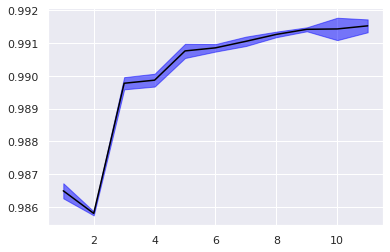

In [ ]:
print("Random Forest Sin crossval")  
est = RandomForestClassifier(n_estimators=5)
est.fit(X_train_ftrs,y_train)
predict = est.predict(x_test_ftrs)
acc = accuracy_score(y_test,predict)
print("accuracy %.3f"%acc)

scores = []
stds = []
estimators = range(1,12,1)
print("RF Curva de aprendizaje")
for i in estimators:
  est = RandomForestClassifier(n_estimators=i)
  s = cross_val_score(est, X_ftr, y, cv=KFold(4, shuffle=True), scoring=make_scorer(accuracy_score))
  scores.append(np.mean(s))
  stds.append(np.std(s))

scores = np.r_[scores]
stds  = np.r_[stds]
print("Desviación máxima: ",np.max(stds))
print("Media máxima: ",np.max(scores))
plt.plot(estimators, scores,label="mean", color="black")
plt.fill_between(estimators, scores-stds, scores+stds, color="blue", alpha=.5, label="std")
plt.show()

In [14]:
#### CONSTRUCCIÓN DE DATASET TEST Y TRAIN CON 15% PARA TEST
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
data = shuffle(data)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
y_train.replace("Shale",0,inplace=True)
y_train.replace("Sandstone",1,inplace=True)
y_train.replace("NoI",2,inplace=True)
y_test.replace("Shale",0,inplace=True)
y_test.replace("Sandstone",1,inplace=True)
y_test.replace("NoI",2,inplace=True)
y_train

325230     2
572469     0
393550     0
865545     1
414105     2
          ..
1000139    1
804548     1
715912     0
692402     1
84562      0
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, Length: 994934, dtype: int64

In [ ]:
##-------------------Aplicación de Redes neuronales
## Condiciones: 
# Una o muchas capas
# diferentes optimizers
# tamaño del epoch
# Learning rate


# Primera prueba -> Optimizer SGD - variable = #Capas intermedias con elu
# Número de clases
cls = len(Counter(y_train).keys())
## Organiza modelo
dnn1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.elu),
  tf.keras.layers.Dense(32, activation=tf.nn.elu),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(512, activation=tf.nn.elu),  
  tf.keras.layers.Dense(128, activation=tf.nn.elu),
  tf.keras.layers.Dense(64, activation=tf.nn.elu),
  tf.keras.layers.Dense(32, activation=tf.nn.elu),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  

#Compila Modelo
dnn1.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn2.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn3.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

#Entrena modelo con los train
dnn1.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)
dnn2.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)
dnn3.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)

#Evalúa el modelo con los test
test_loss1, test_acc1 = dnn1.evaluate(X_test, y_test)
test_loss2, test_acc2 = dnn2.evaluate(X_test, y_test)
test_loss3, test_acc3 = dnn3.evaluate(X_test, y_test)

#Utiliza el modelo
yest1 = dnn1.predict(X_test);
yest2 = dnn2.predict(X_test);
yest3 = dnn3.predict(X_test);


Epoch 1/15
7773/7773 [==============================] - 23s 3ms/step - loss: 49.2967 - accuracy: 0.6157
Epoch 2/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8988 - accuracy: 0.6159
Epoch 3/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8987 - accuracy: 0.6159
Epoch 4/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8988 - accuracy: 0.6159
Epoch 5/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8987 - accuracy: 0.6159
Epoch 6/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8987 - accuracy: 0.6159
Epoch 7/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8987 - accuracy: 0.6159
Epoch 8/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8987 - accuracy: 0.6159
Epoch 9/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8987 - accuracy: 0.6159
Epoch 10/15
7773/7773 [==============================] - 21s 3ms/step - 

In [ ]:
print("1 layer accuracy: ",test_acc1)
print("3 layers accuracy: ",test_acc2)
print("4 layers accuracy: ",test_acc3)

1 layer accuracy:  0.6149951219558716
3 layers accuracy:  0.6149951219558716
4 layers accuracy:  0.6149951219558716


In [ ]:
# Primera prueba -> Optimizer SGD - variable = #Capas intermedias con tanh
# Número de clases
cls = len(Counter(y_train).keys())
## Organiza modelo
dnn1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.tanh),  
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.tanh),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(32, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(512, activation=tf.nn.tanh),  
  tf.keras.layers.Dense(128, activation=tf.nn.tanh),
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(32, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  

#Compila Modelo
dnn1.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn2.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn3.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

#Entrena modelo con los train
dnn1.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)
dnn2.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)
dnn3.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)

#Evalúa el modelo con los test
test_loss1, test_acc1 = dnn1.evaluate(X_test, y_test)
test_loss2, test_acc2 = dnn2.evaluate(X_test, y_test)
test_loss3, test_acc3 = dnn3.evaluate(X_test, y_test)

#Utiliza el modelo
yest1 = dnn1.predict(X_test);
yest2 = dnn2.predict(X_test);
yest3 = dnn3.predict(X_test);

print("1 layer accuracy: ",test_acc1)
print("3 layers accuracy: ",test_acc2)
print("4 layers accuracy: ",test_acc3)

Epoch 1/15
7773/7773 [==============================] - 22s 3ms/step - loss: 0.8879 - accuracy: 0.6192
Epoch 2/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8836 - accuracy: 0.6199
Epoch 3/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8875 - accuracy: 0.6199
Epoch 4/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8868 - accuracy: 0.6199
Epoch 5/15
7773/7773 [==============================] - 22s 3ms/step - loss: 0.8883 - accuracy: 0.6201
Epoch 6/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8879 - accuracy: 0.6205
Epoch 7/15
7773/7773 [==============================] - 22s 3ms/step - loss: 0.8852 - accuracy: 0.6206
Epoch 8/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8846 - accuracy: 0.6202
Epoch 9/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8868 - accuracy: 0.6202
Epoch 10/15
7773/7773 [==============================] - 21s 3ms/step - l

In [ ]:
# Primera prueba -> Optimizer SGD - variable = #Capas intermedias con tanh
# Número de clases
cls = len(Counter(y_train).keys())
## Organiza modelo
dnn1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.tanh),  
  tf.keras.layers.Dense(64, activation=tf.nn.elu),  
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(512, activation=tf.nn.elu),  
  tf.keras.layers.Dense(128, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn4 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(512, activation=tf.nn.tanh),  
  tf.keras.layers.Dense(128, activation=tf.nn.elu),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  

#Compila Modelo
dnn1.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn2.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn3.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn4.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

#Entrena modelo con los train
dnn1.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)
dnn2.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)
dnn3.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)
dnn4.fit(X_train, y_train, epochs=15, batch_size=128,verbose=1)

#Evalúa el modelo con los test
test_loss1, test_acc1 = dnn1.evaluate(X_test, y_test)
test_loss2, test_acc2 = dnn2.evaluate(X_test, y_test)
test_loss3, test_acc3 = dnn3.evaluate(X_test, y_test)
test_loss4, test_acc4 = dnn4.evaluate(X_test, y_test)

#Utiliza el modelo
yest1 = dnn1.predict(X_test);
yest2 = dnn2.predict(X_test);
yest3 = dnn3.predict(X_test);
yest4 = dnn4.predict(X_test);

print("elu-tanh 128-64 nodos accuracy: ",test_acc1)
print("tan-elu 128-64 nodos accuracy: ",test_acc2)
print("elu-tanh 512-128 nodos accuracy: ",test_acc3)
print("tan-elu 512-128 nodos accuracy: ",test_acc4)

Epoch 1/15
7773/7773 [==============================] - 23s 3ms/step - loss: 0.8923 - accuracy: 0.6182
Epoch 2/15
7773/7773 [==============================] - 22s 3ms/step - loss: 0.8922 - accuracy: 0.6188
Epoch 3/15
7773/7773 [==============================] - 22s 3ms/step - loss: 0.8911 - accuracy: 0.6193
Epoch 4/15
7773/7773 [==============================] - 22s 3ms/step - loss: 0.8904 - accuracy: 0.6192
Epoch 5/15
7773/7773 [==============================] - 21s 3ms/step - loss: 0.8882 - accuracy: 0.6192
Epoch 6/15
7773/7773 [==============================] - 22s 3ms/step - loss: 0.8886 - accuracy: 0.6191
Epoch 7/15
7773/7773 [==============================] - 22s 3ms/step - loss: 0.8857 - accuracy: 0.6190
Epoch 8/15
7773/7773 [==============================] - 22s 3ms/step - loss: 0.8901 - accuracy: 0.6193
Epoch 9/15
7773/7773 [==============================] - 23s 3ms/step - loss: 0.8864 - accuracy: 0.6193
Epoch 10/15
7773/7773 [==============================] - 22s 3ms/step - l

In [15]:
# Primera prueba -> Optimizer SGD - variable = #Capas intermedias con tanh
# Número de clases
cls = len(Counter(y_train).keys())
## Organiza modelo
dnn1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn4 = tf.keras.Sequential([
 tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  

#Compila Modelo
dnn1.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn2.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn3.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn4.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

#Entrena modelo con los train
dnn1.fit(X_train, y_train, epochs=15, batch_size=256,verbose=1)
dnn2.fit(X_train, y_train, epochs=15, batch_size=512,verbose=1)
dnn3.fit(X_train, y_train, epochs=15, batch_size=1024,verbose=1)
dnn4.fit(X_train, y_train, epochs=15, batch_size=2048,verbose=1)

#Evalúa el modelo con los test
test_loss1, test_acc1 = dnn1.evaluate(X_test, y_test)
test_loss2, test_acc2 = dnn2.evaluate(X_test, y_test)
test_loss3, test_acc3 = dnn3.evaluate(X_test, y_test)
test_loss4, test_acc4 = dnn4.evaluate(X_test, y_test)

#Utiliza el modelo
yest1 = dnn1.predict(X_test);
yest2 = dnn2.predict(X_test);
yest3 = dnn3.predict(X_test);
yest4 = dnn4.predict(X_test);

print("batch_size=256 accuracy: ",test_acc1)
print("batch_size=512 accuracy: ",test_acc2)
print("batch_size=1024 accuracy: ",test_acc3)
print("batch_size=2048 accuracy: ",test_acc4)

Epoch 1/15
3887/3887 [==============================] - 14s 3ms/step - loss: 0.8925 - accuracy: 0.6173
Epoch 2/15
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8908 - accuracy: 0.6188
Epoch 3/15
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8903 - accuracy: 0.6182
Epoch 4/15
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8896 - accuracy: 0.6189
Epoch 5/15
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8899 - accuracy: 0.6185
Epoch 6/15
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8885 - accuracy: 0.6189
Epoch 7/15
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8782 - accuracy: 0.6184
Epoch 8/15
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8777 - accuracy: 0.6186
Epoch 9/15
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8613 - accuracy: 0.6190
Epoch 10/15
3887/3887 [==============================] - 11s 3ms/step - l

In [17]:
# Primera prueba -> Optimizer SGD - variable = #Capas intermedias con tanh
# Número de clases
cls = len(Counter(y_train).keys())
## Organiza modelo
dnn1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn4 = tf.keras.Sequential([
 tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  

#Compila Modelo
dnn1.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn2.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn3.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn4.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

#Entrena modelo con los train
dnn1.fit(X_train, y_train, epochs=20, batch_size=512,verbose=1)
dnn2.fit(X_train, y_train, epochs=30, batch_size=256,verbose=1)
dnn3.fit(X_train, y_train, epochs=30, batch_size=512,verbose=1)
dnn4.fit(X_train, y_train, epochs=20, batch_size=256,verbose=1)

#Evalúa el modelo con los test
test_loss1, test_acc1 = dnn1.evaluate(X_test, y_test)
test_loss2, test_acc2 = dnn2.evaluate(X_test, y_test)
test_loss3, test_acc3 = dnn3.evaluate(X_test, y_test)
test_loss4, test_acc4 = dnn4.evaluate(X_test, y_test)

#Utiliza el modelo
yest1 = dnn1.predict(X_test);
yest2 = dnn2.predict(X_test);
yest3 = dnn3.predict(X_test);
yest4 = dnn4.predict(X_test);

print("epochs=20, batch_size=512 accuracy: ",test_acc1)
print("epochs=30, batch_size=256 accuracy: ",test_acc2)
print("epochs=30, batch_size=512 accuracy: ",test_acc3)
print("epochs=20, batch_size=256 accuracy: ",test_acc4)

Epoch 1/20
1944/1944 [==============================] - 6s 3ms/step - loss: 0.8933 - accuracy: 0.6165
Epoch 2/20
1944/1944 [==============================] - 6s 3ms/step - loss: 0.8923 - accuracy: 0.6169
Epoch 3/20
1944/1944 [==============================] - 6s 3ms/step - loss: 0.8919 - accuracy: 0.6170
Epoch 4/20
1944/1944 [==============================] - 6s 3ms/step - loss: 0.8895 - accuracy: 0.6187
Epoch 5/20
1944/1944 [==============================] - 5s 3ms/step - loss: 0.8844 - accuracy: 0.6186
Epoch 6/20
1944/1944 [==============================] - 6s 3ms/step - loss: 0.8877 - accuracy: 0.6196
Epoch 7/20
1944/1944 [==============================] - 6s 3ms/step - loss: 0.8702 - accuracy: 0.6191
Epoch 8/20
1944/1944 [==============================] - 6s 3ms/step - loss: 0.8557 - accuracy: 0.6185
Epoch 9/20
1944/1944 [==============================] - 6s 3ms/step - loss: 0.8121 - accuracy: 0.6258
Epoch 10/20
1944/1944 [==============================] - 6s 3ms/step - loss: 0.787

In [18]:
# Número de clases
cls = len(Counter(y_train).keys())
## Organiza modelo
dnn1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  
dnn4 = tf.keras.Sequential([
 tf.keras.layers.Flatten(input_shape=X_train.iloc[0].shape),
  tf.keras.layers.Dense(128, activation=tf.nn.elu),  
  tf.keras.layers.Dense(64, activation=tf.nn.tanh),
  tf.keras.layers.Dense(cls, activation=tf.nn.softmax)
])  

#Compila Modelo
dnn1.compile(optimizer=tf.keras.optimizers.SGD(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn2.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn3.compile(optimizer=tf.keras.optimizers.RMSprop(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
dnn4.compile(optimizer=tf.keras.optimizers.Adadelta(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

#Entrena modelo con los train
dnn1.fit(X_train, y_train, epochs=30, batch_size=256,verbose=1)
dnn2.fit(X_train, y_train, epochs=30, batch_size=256,verbose=1)
dnn3.fit(X_train, y_train, epochs=30, batch_size=256,verbose=1)
dnn4.fit(X_train, y_train, epochs=30, batch_size=256,verbose=1)

#Evalúa el modelo con los test
test_loss1, test_acc1 = dnn1.evaluate(X_test, y_test)
test_loss2, test_acc2 = dnn2.evaluate(X_test, y_test)
test_loss3, test_acc3 = dnn3.evaluate(X_test, y_test)
test_loss4, test_acc4 = dnn4.evaluate(X_test, y_test)

#Utiliza el modelo
yest1 = dnn1.predict(X_test);
yest2 = dnn2.predict(X_test);
yest3 = dnn3.predict(X_test);
yest4 = dnn4.predict(X_test);

print("SGD Optimizer accuracy: ",test_acc1)
print("Adam Optimizer accuracy: ",test_acc2)
print("RMSprop Optimizer accuracy: ",test_acc3)
print("Adadelta Optimizer accuracy: ",test_acc4)

Epoch 1/30
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8926 - accuracy: 0.6180
Epoch 2/30
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8857 - accuracy: 0.6188
Epoch 3/30
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8870 - accuracy: 0.6189
Epoch 4/30
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8785 - accuracy: 0.6186
Epoch 5/30
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8850 - accuracy: 0.6191
Epoch 6/30
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8681 - accuracy: 0.6188
Epoch 7/30
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8360 - accuracy: 0.6191
Epoch 8/30
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8275 - accuracy: 0.6220
Epoch 9/30
3887/3887 [==============================] - 11s 3ms/step - loss: 0.8092 - accuracy: 0.6306
Epoch 10/30
3887/3887 [==============================] - 11s 3ms/step - l